In [31]:
import glob
import json
import os
import sys
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from PIL import Image

from ext.lab2im import utils

rcParams.update({"figure.autolayout": True})

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

sns.set(
    style="whitegrid",
    rc={
        "text.usetex": True,
        "font.family": "serif",
    },
)
sns.color_palette('dark')

# CUSTOM = 'subject_133'

SOME_SUFFIX = ""
# {curtailed | identity | test | | divisible} }

# SOME_SUFFIX_LIST = ["divisible"]
SOME_SUFFIX_LIST = ["curtailed", "identity"]

In [32]:
def get_jitter(dir_name):
    """_summary_

    Args:
        dir_name (_type_): _description_

    Returns:
        _type_: _description_
    """
    return int(dir_name[-1])


def get_skip(file_path):
    """_summary_

    Args:
        file_list (_type_): _description_

    Returns:
        _type_: _description_
    """
    if isinstance(file_path, str):
        return int(file_path.split("-")[-2])
    else:
        return sorted(list({int(item.split("-")[-2]) for item in file_path}))


def some_function(dir_path, error_type="means"):
    # TODO: name this function
    file_list = utils.list_files(dir_path, True, "hcp-" + error_type + "-skip")

    r3_means = [pd.read_json(file, orient="index") for file in file_list]

    col_item1 = lambda x: np.round(np.array(get_skip(x)) * 0.7, 1)
    columns = [
        str(col_item1(file)) + "_" + str(get_jitter(file)) for file in file_list
    ]

    r3_mean_df = pd.concat(r3_means, axis=1)
    print(f"Before removing NaN rows: {r3_mean_df.shape[0]}")

    r3_mean_df = r3_mean_df.dropna(axis=0, how="any")
    print(f"After removing NaN rows: {r3_mean_df.shape[0]}")

    if r3_mean_df.empty:
        return None

    r3_mean_df.columns = columns

    return r3_mean_df

In [33]:
def get_means_and_stds(dir_path, error_type="mean"):
    """_summary_

    Args:
        jitter (_type_): _description_

    Returns:
        _type_: _description_
    """
    r3_mean_df = some_function(dir_path, error_type)

    # filter subjects on the two clusters found in means
    # r3_mean_df = r3_mean_df[get_just_means_for_filtering(dir_path)]

    r3_mean_df = (
        r3_mean_df.stack().reset_index().drop(labels=["level_0"], axis=1)
    )
    r3_mean_df.columns = ["Skip", f"{error_type.capitalize()} Error"]

    r3_mean_df[["Spacing", "Jitter"]] = pd.DataFrame(
        r3_mean_df["Skip"].str.split("_").tolist()
    )
    r3_mean_df["Spacing"] = r3_mean_df["Spacing"].astype(float)
    r3_mean_df = r3_mean_df.drop(labels=["Skip"], axis=1)

    return r3_mean_df

In [34]:
def make_error_boxplot(data_frame, out_file, x_col, y_col, hue_col):
    """_summary_

    Args:
        df (_type_): _description_
        out_file (_type_): _description_
        x_col (_type_): _description_
        hue_col (_type_): _description_
    """
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    bp_ax = sns.boxplot(
        x=x_col,
        y=y_col,
        hue=hue_col,
        data=data_frame,
        palette="binary",
        linewidth=0.5,
        ax=ax, showfliers=False
    )
    fig = bp_ax.get_figure()
    # bp_ax.legend(ncol=10, edgecolor="white", framealpha=0.25)
    # fig.savefig(out_file, dpi=1200, bbox_inches="tight")
    # plt.clf()

    print([item for item in bp_ax.get_yticklabels()])
    print([item for item in bp_ax.get_yticks()])
    # lgnd = plt.legend(frameon=True, fontsize=13)

    ylabel=bp_ax.get_ylabel().replace('Means', 'Mean').replace('Medians', "Median").replace('Stds', 'Std. Dev.')

    bp_ax.set_xlabel(xlabel=bp_ax.get_xlabel() + " (mm)", fontweight='bold').set_fontsize('15')
    bp_ax.set_ylabel(ylabel=ylabel, fontweight='bold').set_fontsize('15')

    # Setting width and color of outer box
    [i.set_linewidth(1.0) for i in bp_ax.spines.values()]
    [i.set_edgecolor("k") for i in bp_ax.spines.values()]

    [bp_ax.axvline(x + 0.5, color="k", linestyle=":", lw=0.5) for x in bp_ax.get_xticks()]
    [bp_ax.axvline(x, 0, 0.020, color="k", lw=1) for x in bp_ax.get_xticks()]
    [bp_ax.axvline(x, 0.98, 1, color="k", lw=1) for x in bp_ax.get_xticks()]

    # print([item for item in bp_ax.get_yticklabels()])
    
    # xticklabels = bp_ax.get_xticklabels()
    # yticklabels = bp_ax.get_yticklabels()
    # bp_ax.set_xticklabels(xticklabels, fontsize=13)
    # bp_ax.set_yticklabels(yticklabels, fontsize=5)
    # plt.draw()

    # Plot legend.
    # lgnd = plt.legend(loc="lower left", numpoints=1, fontsize=10)

    #change the marker size manually for both lines
    # lgnd.legendHandles[0].set_width(5)
    # lgnd.legendHandles[1].set_width(5)
    # lgnd.legendHandles[2].set_width(5)
    # lgnd.legendHandles[3].set_width(5)
    # lgnd.legendHandles[1].set_markersize(6)
    # lgnd.legendHandles[2]._legmarker.set_markersize(6)
    # lgnd.legendHandles[3]._legmarker.set_markersize(6)

    bp_ax.legend(title='Jitter (slices)', frameon=True)

    plt.show()




def plot_file_name(results_dir, type, plot_idx):
    """_summary_

    Args:
        results_dir (_type_): _description_
        plot_idx (_type_): _description_
    """
    out_file = f"{SOME_SUFFIX}-{type}_{plot_idx:02d}.png".strip("-")
    out_file = os.path.join(results_dir, out_file)
    # os.makedirs(os.path.dirname(out_file), exist_ok=True)
    print(out_file)
    return out_file


In [35]:
def plot_registration_error(results_dir, error_str="mean"):
    """_summary_

    Args:
        jitters (_type_): _description_
    """
    # for sub_folder in ["all", "xy", "z"]:
    for sub_folder in ["all"]:
        errors_dir = os.path.join(
            results_dir,
            "-".join(["hcp-errors", SOME_SUFFIX]).strip("-"),
            sub_folder,
        )

        final_df = get_means_and_stds(errors_dir, error_str)

        if final_df is not None:
            y_col = f"{error_str.capitalize()} Error"

            out_file = plot_file_name(errors_dir, error_str, 1)
            make_error_boxplot(final_df, out_file, "Spacing", y_col, "Jitter")

            # out_file = plot_file_name(errors_dir, error_str, 2)
            # make_error_boxplot(final_df, out_file, "Jitter", y_col, "Spacing")
        else:
            print(f"Empty DataFrame for {error_str}")


Before removing NaN rows: 100
After removing NaN rows: 93
/space/calico/1/users/Harsha/SynthSeg/results/hcp-results-20220912-copy/hcp-errors/all/means_01.png
[Text(0, 0.2, '$\\mathdefault{0.2}$'), Text(0, 0.4, '$\\mathdefault{0.4}$'), Text(0, 0.6000000000000001, '$\\mathdefault{0.6}$'), Text(0, 0.8, '$\\mathdefault{0.8}$'), Text(0, 1.0, '$\\mathdefault{1.0}$'), Text(0, 1.2, '$\\mathdefault{1.2}$'), Text(0, 1.4000000000000001, '$\\mathdefault{1.4}$'), Text(0, 1.6, '$\\mathdefault{1.6}$')]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2, 1.4000000000000001, 1.6]


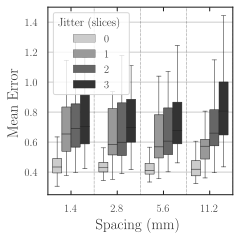

Before removing NaN rows: 100
After removing NaN rows: 93
/space/calico/1/users/Harsha/SynthSeg/results/hcp-results-20220912-copy/hcp-errors/all/stds_01.png
[Text(0, 0.0, '$\\mathdefault{0.0}$'), Text(0, 0.1, '$\\mathdefault{0.1}$'), Text(0, 0.2, '$\\mathdefault{0.2}$'), Text(0, 0.30000000000000004, '$\\mathdefault{0.3}$'), Text(0, 0.4, '$\\mathdefault{0.4}$'), Text(0, 0.5, '$\\mathdefault{0.5}$'), Text(0, 0.6000000000000001, '$\\mathdefault{0.6}$'), Text(0, 0.7000000000000001, '$\\mathdefault{0.7}$'), Text(0, 0.8, '$\\mathdefault{0.8}$')]
[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8]


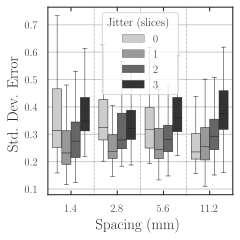

In [36]:
%config InlineBackend.figure_format = 'svg'

PRJCT_DIR = "/space/calico/1/users/Harsha/SynthSeg/results"

FOLDER = "hcp-results-20220912-copy"
# {options: hcp-results | hcp-results-20220527 | hcp-results-20220528}

# set this to a high value if you want to run all subjects
# there are nearly 897 subjects in the dataset
M = 100

full_results_path = os.path.join(PRJCT_DIR, FOLDER)

if not os.path.exists(full_results_path):
    raise Exception("Folder does not exist")

# calculate_registration_error(full_results_path, M)
for stat_key in ["means", "stds"]: #, "medians", "mean-of-means"]:
    plot_registration_error(full_results_path, stat_key)